<img src="https://upload.wikimedia.org/wikipedia/commons/8/89/TheNorthFace_logo.svg" alt="THE NORTH FACE LOGO" width="50%" />

# The North Face e-commerce : boosting online sales !

## Project 🚧

The marketing department would like to take advantage of machine learning solutions to boost online sales on the website : https://www.thenorthface.fr/

They have identified two major solutions that could have a huge effect on the conversion rates :
- Deploying a **recommender system** that will allow to suggest additionnal products to users, that are similar to the items they are already interested in. The recommendations could be materialized by a "you might also be interested by these products..." section that would appear on each product page of the website.
- Improving the structure of the products catalog thanks to **topic extraction**. The idea is to use unsupervised methods to challenge the existing categories : is it possible to find new categories of product that would be more suitable for the navigation on the website ?

## Goals 🎯

The project can be cut into three steps :

1. Identify groups of products that have similar descriptions.

2. Use the groups of similar products to build a simple recommender system algorithm.

3. Use topic modeling algorithms to automatically assess the latent topics present in the item descriptions.

## Scope of this project 🖼️

In this project, you'll work with a corpus of item descriptions from The North Face's product catalog. Data can be found here: 

👉👉<a href="https://www.kaggle.com/cclark/product-item-data?select=sample-data.csv" target="_blank"> The North Face product catalog</a> 👈👈


## Deliverable 📬

To complete this project, your team should: 

- Train at least one **clustering model** on the corpus and display wordclouds describing the clusters
- Develop a simple python code that allows a user to type the id of a product he's interested in, and then get a list of similar items
- Train at least one **TruncatedSVD model** on the corpus and display wordclouds describing the latent topics


### 0-Preprocessing of textual data

- First, you'll have to make some preprocessings to clean the corpus (in particular, don't forget to handle stop words and to lemmatize the documents). For this step, you'll need `pandas` and `spacy`.

- Then, you can to encode the texts with **TF-IDF transformation** (this can be done with scikit learn's `TFIDFVectorizer`)

In [1]:
import pandas as pd 
import numpy as np
import spacy
from tqdm import tqdm

from sklearn.cluster import DBSCAN

import plotly.express as px
import seaborn as sns

In [2]:
path_to_file="/Users/saas1/OneDrive/Escritorio/introduction_to_ python_for_data_science/Projects/Project_5/North_Face/"
raw_data = pd.read_csv(path_to_file+"sample-data.csv")

In [3]:
raw_data

,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."
...,...,...
495,496,Cap 2 bottoms - Cut loose from the maddening c...
496,497,Cap 2 crew - This crew takes the edge off fick...
497,498,All-time shell - No need to use that morning T...
498,499,All-wear cargo shorts - All-Wear Cargo Shorts ...


In [4]:
raw_data.iloc[1,1]

'Active sport boxer briefs - Skinning up Glory requires enough movement without your boxers deciding to poach their own route. The form-fitting Active Sport Boxer Briefs are made from breathable 93% polyester (71% recycled) fabric that\'s fast-wicking, dries quickly and has 7% spandex for stretch; the seamless waistband and soft leg edges won\'t roll or bind. The gusseted, flat-sewn 6" inseam (size M) is offset to prevent inner-thigh chafe. Fly-free with a smooth front panel. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Stretch mesh provides support, open-weave mesh for airflow, wicks efficiently, dries fast"</li> <li>Seamless construction</li> <li>"Flat-sewn, gusseted inseam is set forward to prevent inner-thigh chafe"</li> <li>Fly-free support</li> <li>"Inseam (size M) is 6"""</li></ul><br><br><b>Fabric: </b>"4.6-oz 93% polyester (71% recycled)/7% spandex, with moisture-wicking performance. Recyclable through the Common Threads Recycling Pr

In [5]:
# Remove the tags
for index in raw_data.index:
    raw_data.iloc[index,1]=raw_data.iloc[index,1].replace("li>"," ")
    raw_data.iloc[index,1]=raw_data.iloc[index,1].replace("br>"," ")
    raw_data.iloc[index,1]=raw_data.iloc[index,1].replace("ul>"," ")
    raw_data.iloc[index,1]=raw_data.iloc[index,1].replace("b>"," ")

In [6]:
# Remove punctuation with string and numbers (to add numbers add 0-9)
raw_data['clean_description'] = raw_data['description'].str.replace(r"[^A-Za-z0-9 ]+", " ", regex=True) #0-9

In [7]:
# Remove multiples blanks
raw_data["clean_description"]=raw_data["clean_description"].replace('\s+', ' ', regex=True)


In [8]:
# Modify all the str in lower cases 
raw_data['clean_description'] = raw_data['clean_description'].fillna('').apply(lambda x: x.lower())

In [9]:
raw_data.iloc[1,2]

'active sport boxer briefs skinning up glory requires enough movement without your boxers deciding to poach their own route the form fitting active sport boxer briefs are made from breathable 93 polyester 71 recycled fabric that s fast wicking dries quickly and has 7 spandex for stretch the seamless waistband and soft leg edges won t roll or bind the gusseted flat sewn 6 inseam size m is offset to prevent inner thigh chafe fly free with a smooth front panel recyclable through the common threads recycling program details stretch mesh provides support open weave mesh for airflow wicks efficiently dries fast seamless construction flat sewn gusseted inseam is set forward to prevent inner thigh chafe fly free support inseam size m is 6 fabric 4 6 oz 93 polyester 71 recycled 7 spandex with moisture wicking performance recyclable through the common threads recycling program weight 60 g 2 1 oz made in israel '

In [10]:
## Tokenize the cleaned document
import en_core_web_sm
nlp = en_core_web_sm.load()

tokenized_doc = raw_data['clean_description'].apply(lambda x: nlp(x))

In [11]:
# Import english stop words
from spacy.lang.en.stop_words import STOP_WORDS
words_to_remove_list=["recyclable","thread","recycle","common","oz","program"]
all_stopwords=STOP_WORDS
all_stopwords.update(words_to_remove_list)

# remove stop-words and lemmalize 
tokenized_doc = tokenized_doc.apply(lambda x: [token.lemma_ for token in x if token.text not in all_stopwords and (len(token) > 1)])
#tokenized_doc = tokenized_doc.apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS and (len(token) > 1)])
tokenized_doc

0      [active, classic, boxer, reason, boxer, cult, ...
1      [active, sport, boxer, brief, skin, glory, req...
2      [active, sport, brief, superbreathable, fly, b...
3      [alpine, guide, pant, skin, climb, ice, switch...
4      [alpine, wind, jkt, high, ridge, steep, ice, a...
                             ...                        
495    [cap, bottom, cut, loose, madden, crowd, searc...
496    [cap, crew, crew, take, edge, fickle, weather,...
497    [time, shell, need, use, morning, time, umbrel...
498    [wear, cargo, short, wear, cargo, short, bask,...
499    [wear, short, time, simplify, wear, short, pro...
Name: clean_description, Length: 500, dtype: object

In [12]:
# Create a wordcloud
g=tokenized_doc.tolist()

flat_list = []
for sublist in g:
    for item in sublist:
        flat_list.append(item)

flat_list=' '.join(flat_list)

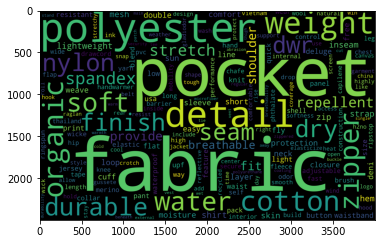

In [13]:
# Import wordcloud and matplotlib
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Instanciate wordcloud
wd = WordCloud(stopwords=STOP_WORDS,collocations=False, width=4000, height=2500)

# Generate wordcloud 
cloud = wd.generate(flat_list)

# Show plot
plt.imshow(cloud)
plt.show()

In [14]:

raw_data["clean_token"] = [" ".join(x) for x in tokenized_doc]
raw_data.head()

,id,description,clean_description,clean_token
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,active classic boxer reason boxer cult favorit...
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,active sport boxer brief skin glory require mo...
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable no f...,active sport brief superbreathable fly brief m...
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,alpine guide pant skin climb ice switch rock t...
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,alpine wind jkt high ridge steep ice alpine ja...


let's create a tf-idf matrix where we can classify each word's importance. 

In [15]:
# Tfidf transformer 
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(raw_data['clean_token'])

# X is a generator. We can transform that as an array
dense = X.toarray()
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
# Create a tf-idf matrix for each token and each document
tf_idf_df=pd.DataFrame(dense, 
             columns=[x for x in vectorizer.get_feature_names_out()], 
             index=["doc_{}".format(x) for x in range(1, 501)] )

In [17]:
tf_idf_df

,000,03,10,100,1000,1021,1027,103,1038,1055,...,young,yvon,zest,zinger,zip,zipper,zippered,zipping,zips,zone
doc_1,0.0,0.0,0.000000,0.076637,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.272758,0.0,0.0,0.0,0.0
doc_5,0.0,0.0,0.049103,0.048445,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.134882,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
doc_496,0.0,0.0,0.000000,0.033272,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_497,0.0,0.0,0.000000,0.065891,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_498,0.0,0.0,0.000000,0.139154,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.137077,0.038743,0.0,0.0,0.0,0.0
doc_499,0.0,0.0,0.000000,0.073305,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.060176,0.000000,0.0,0.0,0.0,0.0


### Part 1 : Groups of products with similar descriptions

For this part, you'll have to train a **clustering model** that will create groups of products for which the descriptions are "close" to each other. 
- You can use `DBSCAN` to make some clustering on the TF-IDF matrix. When dealing with texts, the distance metric to be used is "cosine" instead of "euclidean". You have to find some values for `eps` and `min_samples` that allow to get 10-20 clusters and not too many outliers.
- You can display a `wordcloud` for each cluster to analyze the results and see if the groups contain different words.

In [18]:
tf_idf_df.describe()

,000,03,10,100,1000,1021,1027,103,1038,1055,...,young,yvon,zest,zinger,zip,zipper,zippered,zipping,zips,zone
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.000927,0.000172,0.013603,0.037192,0.000187,0.000112,0.000175,0.002882,0.000160,0.000140,...,0.000288,0.000404,0.000364,0.000196,0.022497,0.033575,0.006953,0.000425,0.001197,0.002986
std,0.010428,0.003843,0.041536,0.036337,0.004184,0.002501,0.003912,0.024852,0.003587,0.003135,...,0.006431,0.009034,0.008130,0.004373,0.049223,0.057338,0.023356,0.006715,0.012513,0.017954
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.035190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.068391,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.051650,0.000000,0.000000,0.000000,0.000000
max,0.135238,0.085942,0.242544,0.156408,0.093553,0.055915,0.087483,0.267312,0.080204,0.070106,...,0.143809,0.202012,0.181801,0.097777,0.302644,0.282668,0.163681,0.106813,0.166768,0.150523


In [19]:
tf_idf_df

,000,03,10,100,1000,1021,1027,103,1038,1055,...,young,yvon,zest,zinger,zip,zipper,zippered,zipping,zips,zone
doc_1,0.0,0.0,0.000000,0.076637,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.272758,0.0,0.0,0.0,0.0
doc_5,0.0,0.0,0.049103,0.048445,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.134882,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
doc_496,0.0,0.0,0.000000,0.033272,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_497,0.0,0.0,0.000000,0.065891,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_498,0.0,0.0,0.000000,0.139154,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.137077,0.038743,0.0,0.0,0.0,0.0
doc_499,0.0,0.0,0.000000,0.073305,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.060176,0.000000,0.0,0.0,0.0,0.0


In [20]:
tf_idf_df.shape

(500, 3823)

In [21]:
X=tf_idf_df.values


In [22]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X=scaler.fit_transform(X)

In [23]:
X

array([[-0.08895348, -0.04476615, -0.3278377 , ..., -0.06337163,
        -0.0957563 , -0.16646769],
       [-0.08895348, -0.04476615, -0.3278377 , ..., -0.06337163,
        -0.0957563 , -0.16646769],
       [-0.08895348, -0.04476615, -0.3278377 , ..., -0.06337163,
        -0.0957563 , -0.16646769],
       ...,
       [-0.08895348, -0.04476615, -0.3278377 , ..., -0.06337163,
        -0.0957563 , -0.16646769],
       [-0.08895348, -0.04476615, -0.3278377 , ..., -0.06337163,
        -0.0957563 , -0.16646769],
       [-0.08895348, -0.04476615, -0.3278377 , ..., -0.06337163,
        -0.0957563 , -0.16646769]])

In [24]:
db = DBSCAN(eps=1, min_samples=180, metric="cosine")

db.fit(X)

DBSCAN(eps=1, metric='cosine', min_samples=180)

In [25]:
np.unique(db.labels_)

array([-1,  0], dtype=int64)

Let's find the best eps and min_samples

In [26]:
for i in range(3,6):
    for j in np.arange(0.8,1.2,0.001):
        db = DBSCAN(eps=j, min_samples=i, metric="cosine")
        db.fit(X)
        if len(np.unique(db.labels_)) >=20:
            print (np.unique(db.labels_,return_counts=True),j,i)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
      dtype=int64), array([317,   9,  27,   4,   3,   4,   3,   3,   8,  20,   6,   3,   4,
         3,  15,   4,   4,   6,   6,   5,   4,   3,   3,   4,   3,   7,
         4,   4,   3,   3,   5,   3], dtype=int64)) 0.8 3
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
      dtype=int64), array([316,   9,  27,   4,   3,   4,   3,   3,   8,  21,   6,   3,   4,
         3,  15,   4,   4,   6,   6,   5,   4,   3,   3,   4,   3,   7,
         4,   4,   3,   3,   5,   3], dtype=int64)) 0.801 3
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64), array([313,   9,  27,   4,   3,   4,   3,   3,   8,  21,   6,   3,   4,
         3,  15,   4,   4,

it seems that the best eps for a min samples of 5 is 0.908.
The best hyperparameters with less outliers is eps=0,912 and min_samples=3 

In [27]:
db = DBSCAN(eps=0.907, min_samples=5, metric="cosine")
db.fit(X)
np.unique(db.labels_,return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19], dtype=int64),
 array([141, 132,  16,   6,  58,   6,  10,   8,  16,  23,  16,   9,   5,
          7,   7,   5,  10,   6,   8,   6,   5], dtype=int64))

In [28]:
db = DBSCAN(eps=0.913, min_samples=3, metric="cosine")
db.fit(X)
np.unique(db.labels_,return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18], dtype=int64),
 array([ 55, 339,   5,  12,   4,   3,  18,   8,   4,   5,   4,   5,   7,
          3,   4,   6,   4,   4,   6,   4], dtype=int64))

In [29]:
final_df=raw_data.copy()

final_df["cluster"]=db.labels_.tolist()

final_df.head()

,id,description,clean_description,clean_token,cluster
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,active classic boxer reason boxer cult favorit...,0
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,active sport boxer brief skin glory require mo...,-1
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable no f...,active sport brief superbreathable fly brief m...,-1
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,alpine guide pant skin climb ice switch rock t...,0
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,alpine wind jkt high ridge steep ice alpine ja...,0


In [30]:
final_df[final_df["cluster"]==0]

,id,description,clean_description,clean_token,cluster
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,active classic boxer reason boxer cult favorit...,0
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,alpine guide pant skin climb ice switch rock t...,0
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,alpine wind jkt high ridge steep ice alpine ja...,0
5,6,Ascensionist jkt - Our most technical soft she...,ascensionist jkt our most technical soft shell...,ascensionist jkt technical soft shell mountain...,0
6,7,"Atom - A multitasker's cloud nine, the Atom pl...",atom a multitasker s cloud nine the atom plays...,atom multitasker cloud atom play courier bag d...,0
...,...,...,...,...,...
493,494,Active boxer briefs - A no-fuss travel compani...,active boxer briefs a no fuss travel companion...,active boxer brief fuss travel companion skivv...,0
494,495,"Active briefs - These featherweight, quick-wic...",active briefs these featherweight quick wickin...,active brief featherweight quick wicke brief c...,0
495,496,Cap 2 bottoms - Cut loose from the maddening c...,cap 2 bottoms cut loose from the maddening cro...,cap bottom cut loose madden crowd search undon...,0
496,497,Cap 2 crew - This crew takes the edge off fick...,cap 2 crew this crew takes the edge off fickle...,cap crew crew take edge fickle weather clearin...,0


Create a DF per cluster

In [31]:
d_cluster = {}

for i in range(-1,19):
    d_cluster[i]=final_df[final_df["cluster"]==i].reset_index(drop=True)

d_cluster[0]

,id,description,clean_description,clean_token,cluster
0,1,Active classic boxers - There's a reason why o...,active classic boxers there s a reason why our...,active classic boxer reason boxer cult favorit...,0
1,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,alpine guide pant skin climb ice switch rock t...,0
2,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,alpine wind jkt high ridge steep ice alpine ja...,0
3,6,Ascensionist jkt - Our most technical soft she...,ascensionist jkt our most technical soft shell...,ascensionist jkt technical soft shell mountain...,0
4,7,"Atom - A multitasker's cloud nine, the Atom pl...",atom a multitasker s cloud nine the atom plays...,atom multitasker cloud atom play courier bag d...,0
...,...,...,...,...,...
334,494,Active boxer briefs - A no-fuss travel compani...,active boxer briefs a no fuss travel companion...,active boxer brief fuss travel companion skivv...,0
335,495,"Active briefs - These featherweight, quick-wic...",active briefs these featherweight quick wickin...,active brief featherweight quick wicke brief c...,0
336,496,Cap 2 bottoms - Cut loose from the maddening c...,cap 2 bottoms cut loose from the maddening cro...,cap bottom cut loose madden crowd search undon...,0
337,497,Cap 2 crew - This crew takes the edge off fick...,cap 2 crew this crew takes the edge off fickle...,cap crew crew take edge fickle weather clearin...,0


Create a wordcloud per cluster

Cluster No. -1


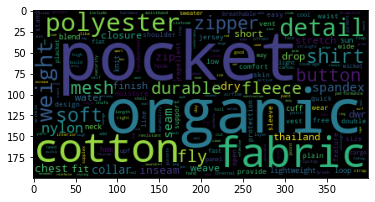

Cluster No. 0


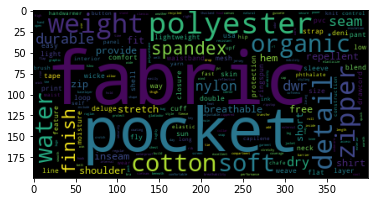

Cluster No. 1


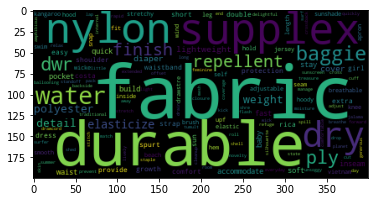

Cluster No. 2


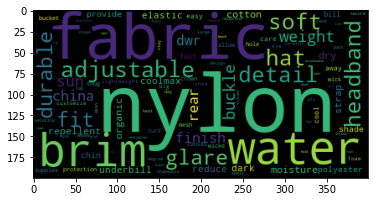

Cluster No. 3


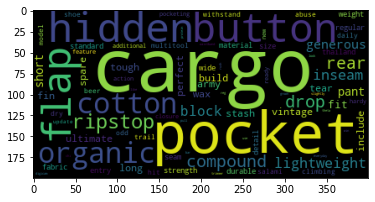

Cluster No. 4


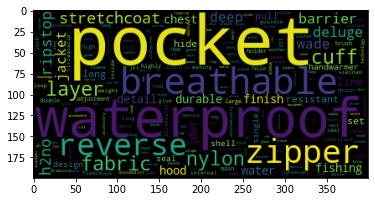

Cluster No. 5


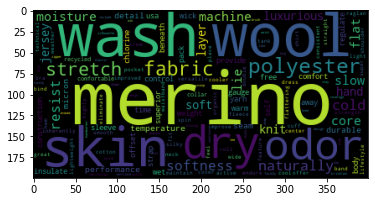

Cluster No. 6


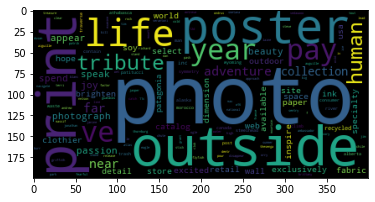

Cluster No. 7


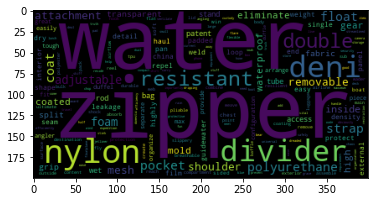

Cluster No. 8


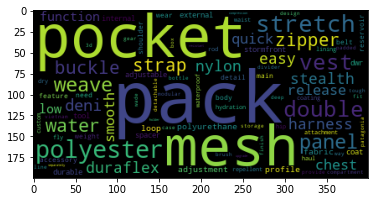

Cluster No. 9


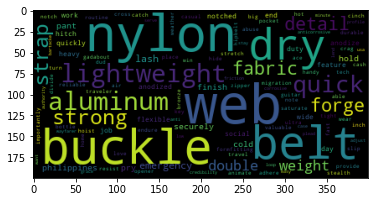

Cluster No. 10


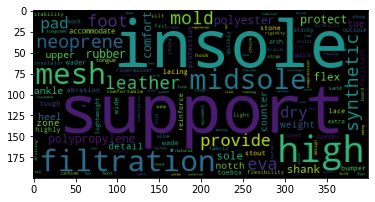

Cluster No. 11


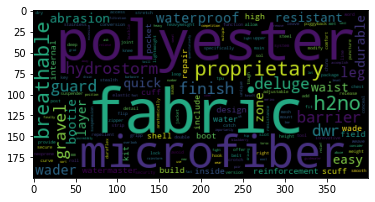

Cluster No. 12


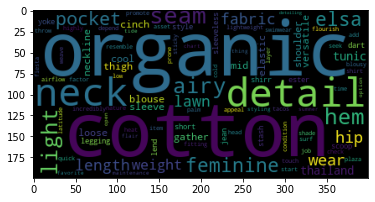

Cluster No. 13


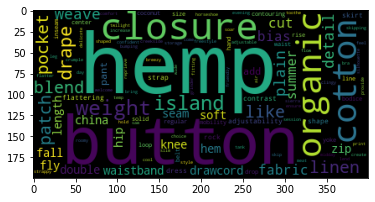

Cluster No. 14


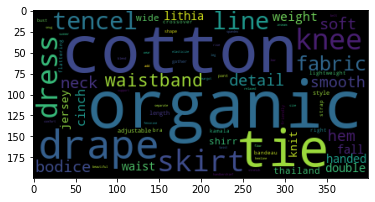

Cluster No. 15


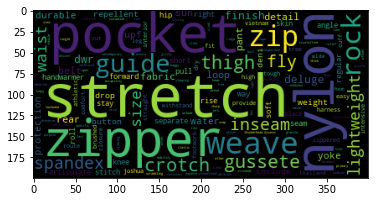

Cluster No. 16


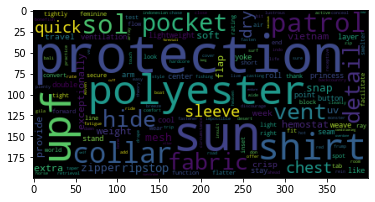

Cluster No. 17


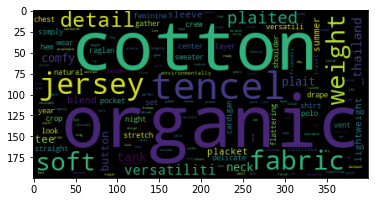

Cluster No. 18


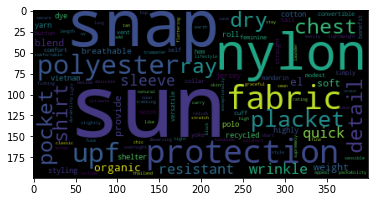

In [32]:
for i in range(-1,19):
    lst=d_cluster[i]["clean_token"].to_list()
    flat_item=' '.join(lst)
    print("Cluster No.",i)
    wd = WordCloud(stopwords=STOP_WORDS,collocations=False)
    cloud = wd.generate(flat_item)
    plt.imshow(cloud)
    plt.show()

### Part 2 - Recommender system

Then, you can use the cluster ids from part 1 to build a **recommender system**. The aim is to be able to suggest to a user some products that are similar to the ones he is interested in. To do this, we will consider that products belonging to the same cluster are similar.

- Create a function named `find_similar_items` that takes an argument `item_id` representing the id of a product, and that returns a list with at least 3 item ids that belong to the same cluster as the product passed in argument
- Use python's `input()` function to allow the user to choose a product and perform some suggestions of similar items

In [33]:
def find_similar_items (item_id):
    s=final_df[final_df["id"]==item_id].head()
    cluster_num=s["cluster"].values[0]
    cluster_df=d_cluster[cluster_num]
    cluster_size=cluster_df.shape[0]

    if cluster_size<=4:
        recomm=cluster_df[cluster_df["id"]!=item_id]
        recomm=recomm.drop(columns=["clean_description","clean_token","cluster"],axis=1).reset_index(drop=True)
    
    else:
        recomm=cluster_df[cluster_df["id"]!=item_id]
        recomm=recomm.sample(n=5,ignore_index=True)
        recomm=recomm.drop(columns=["clean_description","clean_token","cluster"],axis=1)
    
    return(recomm)

In [35]:
item_id=input("Please, indicate the ID of the product")
item_id=int(item_id)
id_items=final_df["id"]#[item for item in range(1,501)]

while item_id not in id_items:
    print("Wrong ID")
    item_id=input("Wrong ID, Please indicate the ID of the product")
    item_id=int(item_id)

find_similar_items(item_id)

,id,description
0,4,"Alpine guide pants - Skin in, climb ice, switc..."
1,393,"Lw travel sling - The feel is open-ended, like..."
2,221,Solid bibiana 1 piece - The sporty Bibiana One...
3,485,Borderless trek zip-off pants - Made for techn...
4,204,Micro puff vest - Too many alpine shiver-fests...


### Part 3 : Topic modeling

*This part is independant from the two others.*

The aim is to use an LSA model to automatically extract latent topics in the products' descriptions.

- Use TruncatedSVD to make some topic extraction from the TF-IDF matrix. You can try values for `n_components` that allow to get 10-20 topics. Save the encoded matrix into a variable named `topic_encoded_df`.
- Contrary to clustering, LSA allows to map each document to a mixing of several topics. For this reason, it's a bit more difficult to interpret the topics as categories : one document can actually be related to several topics at a time. To make things easier, consider extracting the main topic of each document.
- As in part 1, you can display `wordclouds` to analyze the results.

In [36]:
# TruncatedSVD from sklearn
from sklearn.decomposition import TruncatedSVD


In [37]:
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
vectorizer.vocabulary_

{'active': 319,
 'classic': 800,
 'boxer': 626,
 'reason': 2673,
 'cult': 1007,
 'favorite': 1377,
 'cool': 933,
 'especially': 1306,
 'sticky': 3184,
 'situation': 3011,
 'quick': 2631,
 'dry': 1191,
 'lightweight': 2006,
 'underwear': 3566,
 'minimal': 2179,
 'space': 3109,
 'travel': 3482,
 'pack': 2389,
 'expose': 1338,
 'brush': 657,
 'waistband': 3681,
 'offer': 2327,
 'skin': 3022,
 'softness': 3090,
 'panel': 2407,
 'construction': 911,
 'traditional': 3466,
 'fit': 1420,
 'functional': 1524,
 'fly': 1463,
 '100': 3,
 'recycle': 2681,
 'polyester': 2530,
 'moisture': 2203,
 'wicke': 3756,
 'performance': 2459,
 'inseam': 1834,
 'size': 3012,
 'thread': 3401,
 'silky': 2990,
 'capilene': 711,
 'fabric': 1355,
 'ultralight': 3546,
 'breathable': 634,
 'elastic': 1239,
 'comfort': 859,
 'gladiodor': 1567,
 'natural': 2252,
 'odor': 2326,
 'control': 924,
 'garment': 1539,
 'weight': 3732,
 '99': 294,
 'mexico': 2149,
 'sport': 3133,
 'brief': 642,
 'glory': 1576,
 'require': 2740,

In [39]:
# TruncatedSVD from sklearn
from sklearn.decomposition import TruncatedSVD

X=tf_idf_df.values

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100,random_state=122)
lsa = svd_model.fit_transform(X)

In [40]:
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_{}".format(i+1) for i in range(20)], index = tf_idf_df.index)
topic_encoded_df["text"] = final_df['clean_token'].values
topic_encoded_df

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,text
doc_1,0.247465,-0.044382,0.190660,0.078602,-0.124366,-0.025003,-0.052908,-0.017816,-0.160472,0.031624,...,0.052504,0.038599,0.039056,0.030901,-0.048576,-0.007474,-0.011819,0.021757,0.069283,active classic boxer reason boxer cult favorit...
doc_2,0.266332,-0.053954,0.108361,0.100370,-0.031139,0.112351,-0.060179,-0.020374,-0.142633,-0.047401,...,0.174588,0.005117,0.054242,-0.063129,-0.015376,0.129196,0.098778,-0.037310,0.016442,active sport boxer brief skin glory require mo...
doc_3,0.247278,-0.076765,0.114688,0.026910,-0.027969,0.122900,0.017594,0.059700,-0.072746,0.003415,...,0.201776,-0.048472,0.070800,-0.072886,0.005740,0.105767,0.092489,0.002693,0.049583,active sport brief superbreathable fly brief m...
doc_4,0.398770,-0.252771,-0.116987,-0.153265,0.045165,-0.004609,-0.008748,-0.074110,-0.094064,-0.140556,...,0.068045,0.176593,-0.067414,0.016835,0.009219,0.066617,0.193501,0.174853,-0.129429,alpine guide pant skin climb ice switch rock t...
doc_5,0.395061,-0.244375,-0.027220,-0.226664,-0.031829,-0.013152,0.040603,0.042772,0.004833,-0.191419,...,0.009853,0.208633,0.286218,0.059707,-0.027236,-0.057542,-0.024542,-0.001854,0.022116,alpine wind jkt high ridge steep ice alpine ja...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
doc_496,0.314606,-0.070770,0.397431,0.068611,-0.259454,-0.062287,-0.037123,-0.099805,-0.333883,0.089310,...,0.020188,0.073450,0.002249,-0.021298,-0.043104,-0.054233,0.020045,0.051644,-0.010937,cap bottom cut loose madden crowd search undon...
doc_497,0.354823,-0.060687,0.494762,-0.011924,-0.304284,-0.079036,0.013777,-0.002914,-0.219002,0.146616,...,-0.085568,0.094344,0.090476,-0.088428,-0.087800,0.008733,0.026641,-0.045172,0.012494,cap crew crew take edge fickle weather clearin...
doc_498,0.344658,-0.209974,-0.070507,-0.252839,0.003743,-0.145514,0.127852,-0.176625,0.066593,0.032915,...,-0.101475,-0.099477,-0.010585,-0.013865,-0.018193,-0.016694,-0.022841,-0.004338,0.064455,time shell need use morning time umbrella time...
doc_499,0.298121,0.059662,-0.130534,0.333996,0.024701,-0.155297,-0.120788,0.006171,-0.071868,0.030487,...,-0.112597,-0.099377,0.115559,-0.069949,0.111391,-0.103117,0.053678,-0.243264,0.002931,wear cargo short wear cargo short bask glory s...


In [41]:
topic_encoded_df["class_pred"] = [np.argmax(topic) for topic in lsa]
topic_encoded_df["class_pred"].value_counts()

0     227
1      61
2      40
7      27
5      26
3      23
6      21
19     16
8      16
4      12
10      8
15      6
11      6
14      5
16      4
9       2
Name: class_pred, dtype: int64

In [42]:
d_topic = {}

d_topic

for i in range(0,20):
    d_topic[i]=topic_encoded_df[topic_encoded_df["class_pred"]==i].reset_index(drop=True)

d_topic[0]

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,text,class_pred
0,0.247465,-0.044382,0.190660,0.078602,-0.124366,-0.025003,-0.052908,-0.017816,-0.160472,0.031624,...,0.038599,0.039056,0.030901,-0.048576,-0.007474,-0.011819,0.021757,0.069283,active classic boxer reason boxer cult favorit...,0
1,0.266332,-0.053954,0.108361,0.100370,-0.031139,0.112351,-0.060179,-0.020374,-0.142633,-0.047401,...,0.005117,0.054242,-0.063129,-0.015376,0.129196,0.098778,-0.037310,0.016442,active sport boxer brief skin glory require mo...,0
2,0.247278,-0.076765,0.114688,0.026910,-0.027969,0.122900,0.017594,0.059700,-0.072746,0.003415,...,-0.048472,0.070800,-0.072886,0.005740,0.105767,0.092489,0.002693,0.049583,active sport brief superbreathable fly brief m...,0
3,0.398770,-0.252771,-0.116987,-0.153265,0.045165,-0.004609,-0.008748,-0.074110,-0.094064,-0.140556,...,0.176593,-0.067414,0.016835,0.009219,0.066617,0.193501,0.174853,-0.129429,alpine guide pant skin climb ice switch rock t...,0
4,0.395061,-0.244375,-0.027220,-0.226664,-0.031829,-0.013152,0.040603,0.042772,0.004833,-0.191419,...,0.208633,0.286218,0.059707,-0.027236,-0.057542,-0.024542,-0.001854,0.022116,alpine wind jkt high ridge steep ice alpine ja...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,0.400335,-0.186971,-0.144622,0.266361,-0.032371,0.129750,-0.252654,-0.138017,-0.078961,-0.123417,...,-0.086128,-0.126773,-0.056554,0.061671,-0.064427,0.004112,-0.120899,-0.159623,borderless trek zip pant technical performance...,0
223,0.308796,-0.063205,0.229383,0.111106,-0.160987,-0.011418,-0.044789,-0.030777,-0.271535,0.021075,...,0.090552,0.005378,0.018129,-0.034746,0.025024,0.000455,-0.037081,0.041906,active boxer brief fuss travel companion skivv...,0
224,0.289155,-0.044387,0.280139,0.044555,-0.159968,0.020113,-0.034952,-0.042105,-0.218984,0.054134,...,0.058022,0.028356,0.038582,-0.062536,-0.009531,0.010289,-0.011976,0.009220,active brief featherweight quick wicke brief c...,0
225,0.344658,-0.209974,-0.070507,-0.252839,0.003743,-0.145514,0.127852,-0.176625,0.066593,0.032915,...,-0.099477,-0.010585,-0.013865,-0.018193,-0.016694,-0.022841,-0.004338,0.064455,time shell need use morning time umbrella time...,0


Topic No. 0


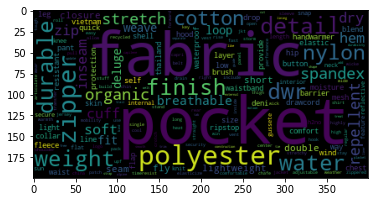

Topic No. 1


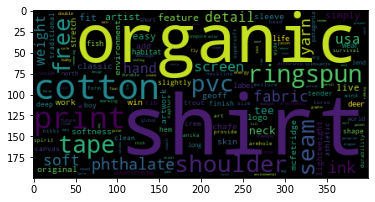

Topic No. 2


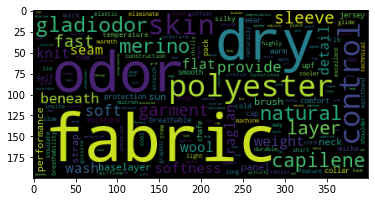

Topic No. 3


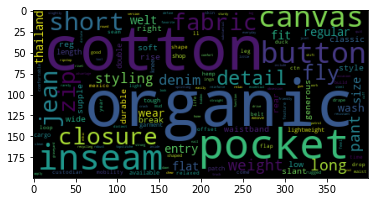

Topic No. 4


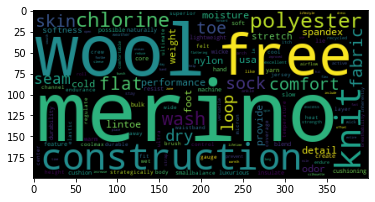

Topic No. 5


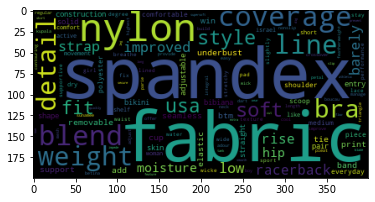

Topic No. 6


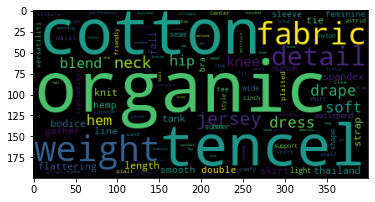

Topic No. 7


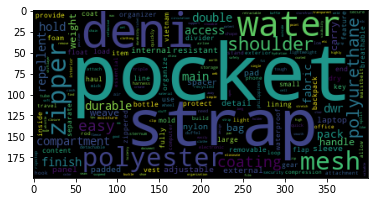

Topic No. 8


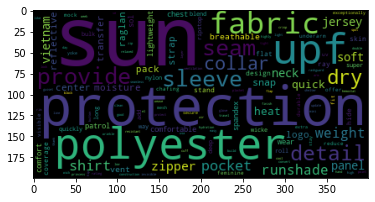

Topic No. 9


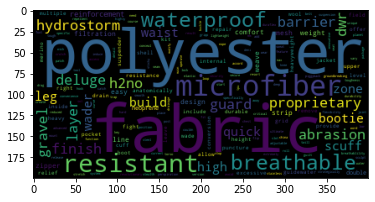

Topic No. 10


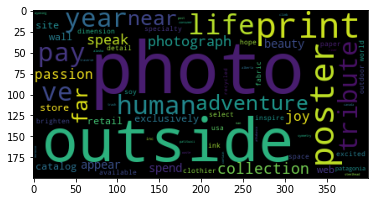

Topic No. 11


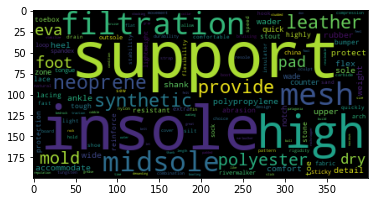

Topic No. 12
No words in this topic
Topic No. 13
No words in this topic
Topic No. 14


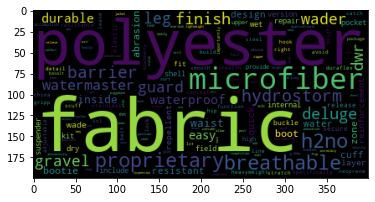

Topic No. 15


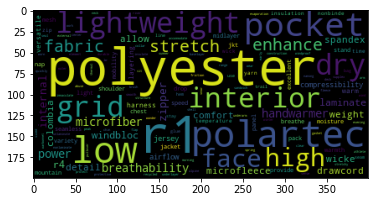

Topic No. 16


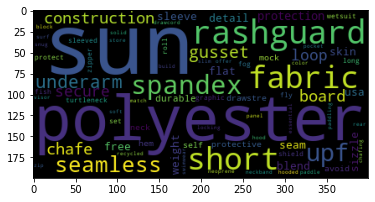

Topic No. 17
No words in this topic
Topic No. 18
No words in this topic
Topic No. 19


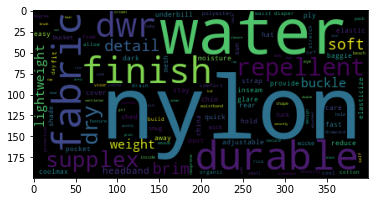

In [43]:
d_topic[i]=topic_encoded_df[topic_encoded_df["class_pred"]==i].reset_index(drop=True)

for i in range(0,20):
    lst=d_topic[i]["text"].to_list()
    flat_item=' '.join(lst)
    print("Topic No.",i)
    try:
        wd = WordCloud(stopwords=STOP_WORDS,collocations=False)
        cloud = wd.generate(flat_item)
        plt.imshow(cloud)
        plt.show()
    except:
        print("No words in this topic")